# Instructions
1. Change the data path in section 2 'Load data function'
2. Just click 'run all code', the code will run on the best module automatically
3. Adjust the hyperparameter in section 7 'Tuning and Running' if you want

## 1. Import lib

In [30]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sn
import time 

## 2.Load date function

In [31]:
# load data
def load_npData(train_data_path='train_data.npy', 
                train_label_path='train_label.npy', 
                test_data_path='test_data.npy', 
                test_label='test_label.npy'):
  train_data = np.load(train_data_path)
  train_label = np.load(train_label_path)

  test_data = np.load(test_data_path)
  test_label = np.load(test_label)
  print("train_raw_data shape: ", np.shape(train_data))
  print("train_raw_label shape: ", np.shape(train_label))
  print("count of train_classes:", np.unique(train_label))

  print("test_data shape: ", np.shape(test_data))
  print("test_label shape: ",np.shape(test_label))
  print("count of test_classes:", np.unique(test_label))

  return train_data, train_label, test_data, test_label, np.unique(train_label)

## 3. Preprocessing data
- Standardisation
- Normalisation

In [32]:
# standardize dataset
def standardizeData(dataset):
  """
  here we assume that dataset size is (samples, features)
  """
  # print("shape before norm:",dataset.shape)
  # subtract mean
  mean = np.mean(dataset, axis=0)

  # normalize variance
  std = np.std(dataset,axis=0)

  # print("shape after norm:",dataset.shape)
  return (dataset-mean)/(std+1e-8)

# normalize dataset
def normalizeData(dataset):
  """
  here we assume that dataset size is (samples, features)
  """
  # get max and min
  max = np.max(dataset,axis=0)
  min = np.min(dataset,axis=0)

  return (dataset-min)/(max-min+1e-8)

## 4. Activation function class

In [33]:
# activation function
class Activation(object):
    def __relu(self, x):
        return np.maximum(0,x)

    def __relu_deriv(self, a):
        a[a > 0] = 1
        a[a <= 0] = 1e-8
        return a

    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2

    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    def __softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
   
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return s * (1 - s)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__sigmoid_derivative
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv

## 5. Hidden layer class

In [34]:
# Define each Hiddenlayer
class Hiddenlayer(object):
  def __init__(self, number_in, number_out, W=None, B=None, activation_this_layer='tanh', 
               activation_last_layer='tanh'):
    """
    number_in: input number of this layer
    number_out: output number of this layer
    W and B are the parameters of this layer:
    W is number_out * number_in
    B is number_out * 1

    activation_this_layer: activation function in this layer
    activation_last_layer: activation function in last layer
    """
    # record the string value of activation function
    self.func = activation_this_layer
    self.lastFunc = activation_last_layer

    # set up foward propargation function
    self.activation_this_layer = Activation(activation_this_layer).f

    # set up backward propargation function
    self.activation_deriv = Activation(activation_last_layer).f_deriv
    
    # set up units number in this hidden layer
    self.unitsNumber = number_out

    # momentum variable
    self.v_dw = 0
    self.v_db = 0
    self.v_gam_norm = 0
    self.v_beta_norm = 0

    # RMSprop variable
    self.s_dw = 0
    self.s_db = 0
    self.s_gam_norm = 0
    self.s_beta_norm = 0

    # initialize W
    if W==None:
      self.W = np.random.randn(number_out, number_in) * np.sqrt(2/number_in)
    
    # initialize B
    if B==None:
      self.B = np.zeros((number_out, 1))
    
    # initialize parameters for batch norm 
    self.gamma_norm = np.random.randn(number_out, 1)+1e-8
    self.beta_norm = np.random.randn(number_out, 1)+1e-8
    

  # define forward propergation function
  def forward(self, input, drop_out_rate, isOutputLayer=False, batchNorm=False):
    """
    input: numpy matrix   size = n(features) * m(batch samples)
        input for each layer

    drop_out_rate: float
        rate of dropout algorithm

    isOutputLayer: bool
        'True' if this layer is the output layer

    batchNorm: bool
        'True' indicates batch norm is on

    self.A_input is the input of each layer (forward direction)
    self.A is the output of each layer (forward direction)
    """
    # record the input of this layer
    self.A_input = input

    # z = wx+b
    self.Z = np.dot(self.W, input) + self.B

    # use the BN algorithm or not
    if batchNorm:
      # Batch norm (to solve Internal Covariate Shift problem)
      self.mean_Z = np.mean(self.Z,axis=1)[:,np.newaxis]
      self.sqr_var = np.sqrt(np.var(self.Z,axis=1)+1e-8)[:,np.newaxis]
      self.Z_norm = (self.Z-self.mean_Z) / self.sqr_var
      self.Z_wave = self.Z_norm * self.gamma_norm + self.beta_norm

    # define forward activation function
    if self.activation_this_layer == None:
      print("Activation function cannot be 'None' !")
    else:
      # record the output of this layer A[l]
      if batchNorm:
        self.A = self.activation_this_layer(self.Z_wave)
      else:
        self.A = self.activation_this_layer(self.Z)

    # dropout
    if isOutputLayer == False and drop_out_rate >= 0:
      # creating mask for dropout and save the mask
      self.mask = np.random.uniform(0,1,size=(self.unitsNumber,1)) <= drop_out_rate
      self.A = self.A * self.mask
      self.A /= drop_out_rate
    
    # output layer doesn't need dropout
    if isOutputLayer==True:
      self.mask = np.zeros(self.unitsNumber) == 0

    return self.A
  
  # define backward prop
  def backward(self, input, batchSize, lambd, penalty, batchNorm):
    """
    input: numpy matrix   size=(n[L],m)
        input is dz[L]
    
    batchSize: int
        indicates the size of batch
    
    lambd: float
        lambda of L2 regularisation
    
    penalty: string
        default is 'l2', means use l2 regularisation
    
    batchNorm: bool
        'True' indicates batch norm is on

    NOTE:
    the input is dz[L]
    the output is dz[L-1]
    """

    dz = input

    # use BN algorithm or not
    if batchNorm:
      dz_wave = dz
      # d_gamma
      self.d_beta_norm = np.sum(dz_wave,axis=1)[:,np.newaxis]
      # d_beta
      self.d_gamma_norm = np.sum(dz_wave * self.Z_norm, axis=1)[:,np.newaxis]
      # d_Z_norm
      self.d_Z_norm = dz_wave * self.gamma_norm
      # d_ivar
      d_ivar = np.sum((self.Z - self.mean_Z) * self.d_Z_norm, axis=1)[:,np.newaxis]
      # d_mu1
      d_mu1 = self.d_Z_norm * 1 / self.sqr_var
      # d_sqr_var
      d_sqr_var = -1 / (self.sqr_var**2) * d_ivar

      # d_var
      d_var = 0.5 * 1 / np.sqrt(self.sqr_var) * d_sqr_var
      # d_sq
      d_sq = 1. / dz_wave.shape[1] * np.ones((dz_wave.shape[0],dz_wave.shape[1])) * d_var
      # d_mu2
      d_mu2 = 2 * (self.Z - self.mean_Z) * d_sq

      d_x1 = d_mu1 + d_mu2
      d_mu = -1 * np.sum(d_x1, axis=1)[:,np.newaxis]
      d_x2 = 1. / dz_wave.shape[1] * np.ones((dz_wave.shape[0],dz_wave.shape[1])) * d_mu
      dz = d_x1 + d_x2
    
    # choose regularisation algorithm to calculate dw
    if penalty == 'l2':
      self.dw = np.dot(dz,self.A_input.T)/batchSize + self.W * lambd / batchSize
    elif penalty == 'l1':
      pass
    
    # calc db
    self.db = np.mean(dz,axis=1,keepdims=True)

    # calc dz[L-1]
    if self.activation_deriv:
        input = np.dot(self.W.T, dz) * self.activation_deriv(self.A_input)
    else:
        print("No activation_deriv")
    output_da = input

    # print("input.shape {}, self.A.shape {}, \
    # dz.shape {}, dw.shape {}, db.shape{}".format(input.shape,
    #                                              self.A.shape,
    #                                              dz.shape, 
    #                                              self.dw.shape, 
    #                                              self.db.shape))
    return output_da, self.dw, self.db


## 6. MLP class

In [35]:
# define the NN
class MLP(object):
  def __init__(self, unitsNumber_list, typeOfActivation):
    """
    unitsNumber_list type: np array
    unitsNumber_list     : number of units in each layer([0] is NOT the input layer)
    typeOfActivation type: np array
    typeOfActivation     : activation function of each layer e.g.,[None, 'tanh', 'sigmoid', 'ReLU']

    NOTE: 
    layer[0] is the first hidden layer which is the second layer in net
    """
    self.__layers = []
    self.__typeOfActivation = typeOfActivation
    self.numberOfClasses = unitsNumber_list[-1]

    # "len(unitsNumber_list)-1" to prevent list index out of range
    for i in range(len(unitsNumber_list)-1):
      self.__layers.append(Hiddenlayer(unitsNumber_list[i],
                                       unitsNumber_list[i+1],
                                       activation_this_layer=typeOfActivation[i+1],
                                       activation_last_layer=typeOfActivation[i]))
      print("layer: ",i,
            ", last: ",typeOfActivation[i],
            ", this: ",typeOfActivation[i+1])

  def forward(self, input, drop_out_rate,batchNorm=False):
    output = None
    # input is a matrix of n*m
    for layer_i in range(len(self.__layers)):
      output = self.__layers[layer_i].forward(input, drop_out_rate, (layer_i<len(self.__layers)-1), batchNorm)
      input = output
    return output

  def backward(self, loss_deriv, batchSize, lambd, penalty,batchNorm):
    output_deriv = None
    output_dw = None
    output_db = None

    for layer in reversed(self.__layers):
      # print('layer func:',layer.func,', last layer func: ', layer.lastFunc)
      output_deriv,dw,db = layer.backward(loss_deriv, batchSize, lambd, penalty,batchNorm)
      output_dw = dw
      output_db = db
      loss_deriv = output_deriv
    
    return output_deriv, output_dw, output_db
  
  # encode the targets Y
  def labelEncoder(self, Y, classNumber):
    '''
    y : np array
        a list of targets

    classNumber: int
        number of the classes

    Example:
    if classNumber=3
    Y = [2,0,1]
    Y_sf = [[0,1,0],
            [0,0,1],
            [1,0,0]]
    '''
    # Y = np.random.randint(9,size=100)
    Y = Y.flatten()
    Y_sf = np.zeros((classNumber,len(Y)))
    for y in range(len(Y)):
        classNum = Y[y]
        Y_sf[classNum][y] = 1

    return Y_sf
  
  # calculate l1 penalty
  def l1_penalty(self, lambd):
    pass

  # calculate l2 penalty
  def l2_penalty(self, lambd):
    l2_penalty = 0
    for layer in self.__layers:
      l2_penalty += np.sum(np.square(layer.W))
    l2_penalty = l2_penalty * lambd / 2 / self.batchSize
    return l2_penalty
  
  # calculate cross entropy
  def crossEntropyLoss_andDeriv(self, Y_hat, Y, lambd=0.1, penalty='l2'):
    """
    here we assume that
    Y_hat is n[L]*m (m is 1)
    Y is n[L]*m (m is 1)
    (L indicates the output layer)
    """
    # adjust the row and column of Y
    Y = np.atleast_2d(Y)
    if Y.shape[0] != self.__layers[-1].unitsNumber:
      Y = Y.T
    
    # calculate Cross Entropy with l2 penalty
    if penalty == 'l2':
      loss = -np.mean(Y * np.log(Y_hat + 1e-8),axis=1) + self.l2_penalty(lambd)
    elif penalty == 'l1':
      loss = -np.mean(Y * np.log(Y_hat + 1e-8),axis=1) + self.l1_penalty(lambd)
    # calculate derivative of Cross Entropy
    loss_deriv = Y_hat - Y

    # print("Y_hat shape, Y shape, loss shape, loss_deriv shape : ",
    #       Y_hat.shape, 
    #       Y.shape, 
    #       loss.shape, 
    #       loss_deriv.shape)

    return loss,loss_deriv # (n[L],m), (n[L],m)
  
  
  def updatePara(self, learningRate, beta_momentum, momentum, beta_RMS, adam, batchNorm):
    i=1
    for layer in self.__layers:
      # if batchNorm:
      #   layer.gamma_norm -= learningRate * layer.d_gamma_norm
      #   layer.beta_norm -= learningRate * layer.d_beta_norm
      # mommentum
      layer.v_dw = beta_momentum*layer.v_dw + (1-beta_momentum) * layer.dw
      layer.v_db = beta_momentum*layer.v_db + (1-beta_momentum) * layer.db
      
      # bias correct
      v_dw_correct = layer.v_dw/(1-beta_momentum**i)
      v_db_correct = layer.v_db/(1-beta_momentum**i)

      if batchNorm:
        layer.v_gam_norm = beta_momentum*layer.v_gam_norm + (1-beta_momentum) * layer.d_gamma_norm
        layer.v_beta_norm = beta_momentum*layer.v_beta_norm + (1-beta_momentum) * layer.d_beta_norm
        v_d_gam_correct = layer.v_gam_norm/(1-beta_momentum**i)
        v_d_beta_correct = layer.v_beta_norm/(1-beta_momentum**i)

      if adam:
        # RMSprop
        layer.s_dw = beta_RMS*layer.s_dw + (1-beta_RMS) * layer.dw * layer.dw
        layer.s_db = beta_RMS*layer.s_db + (1-beta_RMS) * layer.db * layer.db
        
        # bias correct
        s_dw_correct = layer.s_dw/(1-beta_RMS**i)
        s_db_correct = layer.s_db/(1-beta_RMS**i)
        
        # update W and B
        layer.W -= learningRate * v_dw_correct/(np.sqrt(s_dw_correct)+1e-8)
        layer.B -= learningRate * v_db_correct/(np.sqrt(s_db_correct)+1e-8)

        if batchNorm:
          layer.s_gam_norm = beta_RMS*layer.s_gam_norm + (1-beta_RMS) * layer.d_gamma_norm * layer.d_gamma_norm
          layer.s_beta_norm = beta_RMS*layer.s_beta_norm + (1-beta_RMS) * layer.d_beta_norm * layer.d_beta_norm

          s_d_gam_correct = layer.s_gam_norm/(1-beta_RMS**i)
          s_d_beta_correct = layer.s_beta_norm/(1-beta_RMS**i)

          layer.gamma_norm -= learningRate * v_d_gam_correct/(np.sqrt(s_d_gam_correct)+1e-8)
          layer.beta_norm -= learningRate * v_d_beta_correct/(np.sqrt(s_d_beta_correct)+1e-8)
      elif momentum:
        # update W and B
        layer.W -= learningRate * layer.v_dw
        layer.B -= learningRate * layer.v_db
        if batchNorm:
          layer.gamma_norm -= learningRate * layer.v_gam_norm
          layer.beta_norm -= learningRate * layer.v_beta_norm
      else:
        # update W and B
        layer.W -= learningRate * layer.dw
        layer.B -= learningRate * layer.db
        if batchNorm:
          layer.gamma_norm -= learningRate * layer.d_gamma_norm
          layer.beta_norm -= learningRate * layer.d_beta_norm
      i+=1
  
  def fit(self, X, y, learning_rate=0.1, learning_rate_dacay=0.9, 
          epochs=100, print_interval=10,
          batchSize=1024, iter_each_epoch=3,
          beta_momentum=0.9, momentum=False,
          beta_RMS=0.999, adam=False,
          lambd=0.1, drop_out_rate=0.5, penalty='l2', batchNorm=False, early_stop=False, calc_val=False):
    """
    X: training data m*n (n is the number of features and m is the number of samples)
    y: label of training data 1*m (m is the number of samples)
    print_interval:print every "print_interval" iterations
    beta_momentum: beta in momentum
    Momentum: control momentum turn on/off
    """

    X = np.array(X)
    y = np.array(y)
    # here we ensure X is n*m
    if len(y) == X.shape[0]:
      X = X.T
    
    # define the return
    loss_return = np.zeros(epochs)
    val_loss_return = np.zeros(epochs)

    # define the batchsize
    if batchSize>X.shape[1]:
      print("Batchsize cannot greater than number of samples")
      return
    # set batchSize
    self.batchSize = batchSize
    # record accuracy
    accuracy_train = np.zeros(int(epochs/print_interval))
    accuracy_val_arr = np.zeros(int(epochs))

    # early_stop count
    early_stop_count = 0
    max_val_acc = 0
    max_test_acc = 0
    descend = False
    for times in range(epochs):

      # 1. set iteration times
      iter_times = int(X.shape[1]/self.batchSize)

      loss_arr = np.zeros(iter_each_epoch)
      val_loss_arr = np.zeros(iter_each_epoch)

      shuffled_x_indexes = np.random.permutation(X.shape[1])
      for it in range(iter_each_epoch):
        # 2. randomly choose a number from 0 to iter_times
        # i=np.random.randint(iter_times)
        indexes = shuffled_x_indexes[it*self.batchSize:(it*self.batchSize+self.batchSize)]
        # indexes = np.arange(batchSize)

        # 3. pick one batch by i
        # miniBatch = X[:,i*self.batchSize:(i*self.batchSize+self.batchSize)]
        miniBatch = X[:,indexes]
        
        # 4. go foward
        A_output = self.forward(miniBatch, drop_out_rate, batchNorm)
        self.batchNorm = batchNorm

        # 5. get the batch targets
        # miniBatch_y = y[i*self.batchSize:(i*self.batchSize+self.batchSize)]
        miniBatch_y = y[indexes]

        # 6. encode targets for calculating softmax loss
        self.encoded_y = self.labelEncoder(miniBatch_y, self.__layers[-1].unitsNumber)
        
        # 7. calculate loss (here use cross entropy loss)
        loss, loss_deriv = self.crossEntropyLoss_andDeriv(A_output, self.encoded_y, lambd=lambd, penalty=penalty)
        
        # loss_arr[it] = np.mean(loss)
        loss_arr[it] = np.mean(loss)
        
        # 8. go backward
        output_deriv, output_dw, output_db = self.backward(loss_deriv, self.batchSize, lambd, penalty, batchNorm)

        # 9. update parameters W and B by gradient descend
        self.updatePara(learning_rate,beta_momentum,momentum,beta_RMS,adam,batchNorm)

        # val loss and acc
        if calc_val:
          # loss
          val_A = self.forward(val_data.T, -1,batchNorm=batchNorm)
          val_encoded_y = self.labelEncoder(val_label, self.__layers[-1].unitsNumber)
          val_loss, val_loss_deriv = self.crossEntropyLoss_andDeriv(val_A, val_encoded_y, lambd=0)
          val_loss_arr[it] = np.mean(val_loss)

      # print("Output {}, Loss {}, Loss_d {}, dw {}, db {}".format(A_output,
      #                                                            loss,
      #                                                            loss_deriv,
      #                                                            output_dw,
      #                                                            output_db))

      # 10. append the loss and print
      loss_return[times] = np.mean(loss_arr)
      val_loss_return[times] = np.mean(val_loss_arr)
      # val acc
      if calc_val:
        # acc
        accuracy_val, yhat_val, y_val = self.predict(val_data,val_label)
        accuracy_val_arr[int(times)] = accuracy_val

      if times % print_interval == 0:
        # 11. update learning rate
        # learning_rate *= 1/(1+times*decay_rate)
        if learning_rate_dacay is not None:
          learning_rate *= learning_rate_dacay

        # 12. append train accuracy
        accuracy, yhat, y = self.predict(X,y)
        accuracy_train[int(times / print_interval)] = accuracy
        print('\n')
        print("Batch index: {}, Batch size: {}, Run batch count: {}".format(it,miniBatch.shape,iter_each_epoch))
        print("Epoch {}/{}, learning rate {}".format(times,epochs,learning_rate))
        print("train_loss {}, train_accuracy {}".format(loss_return[times],accuracy))

        # append validation accuracy
        if calc_val:
          print("val_loss {}, val_accuracy {}".format(val_loss_return[times],accuracy_val))
      
      # if early stopping, then find the max validation accuracy within the 50 epochs later
      if early_stop:
        # if np.abs(val_loss_return[times-1]-val_loss_return[times]) <= 1e-4:
        if accuracy_val_arr[int(times)]-accuracy_val_arr[int(times)-1] < 0:
          descend = True
        
        if descend:
          tmp_max = accuracy_val_arr[int(times)]
          if tmp_max > max_val_acc:
            max_val_acc = tmp_max
            early_stop_count=0

            accuracy_e = accuracy
            acc_test, a, b = self.predict(test_data, test_label)
            global best_model_on_test
            best_model_on_test = np.array([a, b])
            max_test_acc = max_test_acc if max_test_acc > acc_test else acc_test
          else:
            early_stop_count+=1
            if early_stop_count>=30:
              print('\n')
              print("Early stop epoch {}/{}, train acc {}, max val acc {}, max_test_acc {}".format(times,epochs,accuracy_e,max_val_acc,max_test_acc))
              print("train_loss {}, val_loss {}".format(loss_return[times],val_loss_return[times]))
              current_epoch = times

              global tok
              tok = time.perf_counter()
              return loss_return, accuracy_train, val_loss_return, accuracy_val_arr, current_epoch
          print('The training process will stop after ',30-early_stop_count,' epochs')
    current_epoch = times
    tok = time.perf_counter()
    return loss_return, accuracy_train, val_loss_return, accuracy_val_arr, current_epoch

  def predict(self, X, Y):
    X = np.array(X)
    Y = np.array(Y).flatten()
    # here we ensure X is n*m
    if len(Y) == X.shape[0]:
      X = X.T
    A = self.forward(X,-1,batchNorm=self.batchNorm)
    y_hat = np.argmax(A, axis=0).flatten()
    accuracy = (y_hat == Y).mean()
    return accuracy * 100, y_hat, Y


## 7. Tuning and Running

train_raw_data shape:  (50000, 128)
train_raw_label shape:  (50000, 1)
count of train_classes: [0 1 2 3 4 5 6 7 8 9]
test_data shape:  (10000, 128)
test_label shape:  (10000, 1)
count of test_classes: [0 1 2 3 4 5 6 7 8 9]


train_data shape:  (49000, 128)
train_label shape:  (49000, 1)
val_data shape:  (500, 128)
val_label shape:  (500, 1)
val_data shape:  (10000, 128)
val_label shape:  (10000, 1)
layer:  0 , last:  tanh , this:  tanh
layer:  1 , last:  tanh , this:  tanh
layer:  2 , last:  tanh , this:  relu
layer:  3 , last:  relu , this:  softmax


Batch index: 97, Batch size: (128, 500), Run batch count: 98
Epoch 0/300, learning rate 0.005
train_loss 0.41501789020167007, train_accuracy 41.8734693877551
val_loss 0.19720575640846327, val_accuracy 42.199999999999996


Batch index: 97, Batch size: (128, 500), Run batch count: 98
Epoch 1/300, learning rate 0.005
train_loss 0.3436570273523362, train_accuracy 50.90408163265307
val_loss 0.15763129818789637, val_accuracy 47.0


Batch index

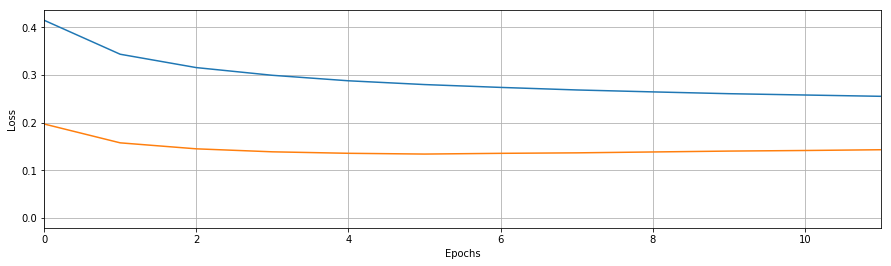

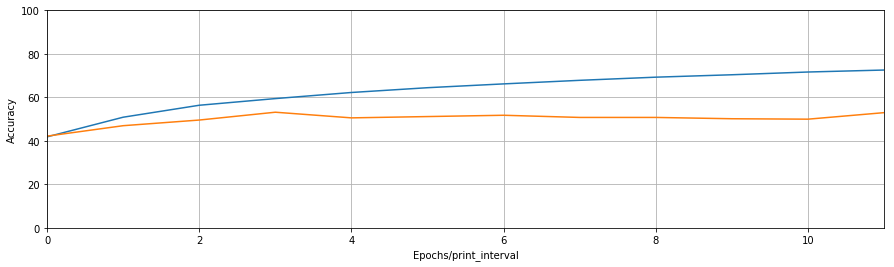

In [36]:
### Tuning Part ###
# dataset size
TRAIN_SIZE = 49000 # traing dataset size
VAL_SIZE = 500 # validation dataset size
TEST_SIZE =10000 # test dataset size
BATCH_SIZE=500 # size of batch
PRINT_INTERVAL=1 # interval for log print
CAL_VAL=True # show/NOT show the validation loss and accuracy in log print

# iteration related para
LEARNING_RATE = 0.005 # the initial learning rate
LEARNING_RATE_DECAY = 1 # the decay rate of the learning
EPOCHS = 300 # number of epochs to run
ITER_EACH_EPOCH=int(TRAIN_SIZE / BATCH_SIZE) # number of batches to iterate in each epoch



EARLY_STOP=True # early stopping

# Optomizers
MOMENTUM=False # momentum turned on/off
ADAM=True # adam turned on/off

# Regularisation
DROP_OUT_RATE=-1 # rate of dropout
PENALTY='l2' # use l2 regularisation
LAMBD=0.3 # lambda for l2

# Batch norm
BATCH_NORM=True # turn on/off batch normalisation


### Running Part ###
# 1. load data
train_raw_data, train_raw_label, test_raw_data, test_raw_label, classes = load_npData()
numberOfClass = len(classes)

# 2. standardize or normalize data
# train_raw_data = standardizeData(train_raw_data)
# test_raw_data = standardizeData(test_raw_data)
train_raw_data = normalizeData(train_raw_data)
test_data = normalizeData(test_raw_data)

# 3. seperate data
train_data = train_raw_data[0:TRAIN_SIZE,:]
train_label = train_raw_label[0:TRAIN_SIZE]
val_data = train_raw_data[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE,:]
val_label = train_raw_label[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]
test_data = test_raw_data[0:TEST_SIZE,:]
test_label = test_raw_label[0:TEST_SIZE]

print("\n")
print("train_data shape: ", np.shape(train_data))
print("train_label shape: ", np.shape(train_label))
print("val_data shape: ", np.shape(val_data))
print("val_label shape: ", np.shape(val_label))
print("val_data shape: ", np.shape(test_data))
print("val_label shape: ", np.shape(test_label))

# 4. create a nn
tik = time.perf_counter()
tok = time.perf_counter()
best_model_on_test = None # 0: yhat 1: y
nn = MLP([train_data.shape[1], 256, 64, 64, numberOfClass], ['tanh','tanh','tanh','relu','softmax'])
cross_entropy_loss, accuracy_train, val_loss, accuracy_val , current_epoch = nn.fit(train_data,train_label, 
                                                                              learning_rate=LEARNING_RATE, 
                                                                              learning_rate_dacay=LEARNING_RATE_DECAY,
                                                                              epochs=EPOCHS, 
                                                                              print_interval=PRINT_INTERVAL, 
                                                                              batchSize=BATCH_SIZE, 
                                                                              iter_each_epoch=ITER_EACH_EPOCH, 
                                                                              momentum=MOMENTUM, 
                                                                              adam=ADAM, 
                                                                              drop_out_rate=DROP_OUT_RATE,
                                                                              penalty=PENALTY, 
                                                                              lambd=LAMBD, 
                                                                              batchNorm=BATCH_NORM, 
                                                                              early_stop=EARLY_STOP, 
                                                                              calc_val=CAL_VAL)
# runninf time
# tok = time.perf_counter()
print(f"running training and testing of the model takes {tok - tik:0.4f} seconds")
# 5. print the test result
# accuracy, yhat, y = nn.predict(test_data,test_label)
# print("test data acc: ",accuracy)
# print(np.max(accuracy_val),np.argmax(accuracy_val),accuracy_train[np.argmax(accuracy_val)])

# 6. plot
def to_percent(temp, position):
  return '%1.0f'%(PRINT_INTERVAL*temp)

pl.figure(figsize=(15,4))
pl.plot(cross_entropy_loss)
pl.plot(val_loss)
pl.xlabel("Epochs")
pl.ylabel("Loss")
pl.xlim(0, current_epoch-30)
pl.grid()

pl.figure(figsize=(15,4))
pl.plot(accuracy_train)
pl.plot(accuracy_val)
pl.gca().xaxis.set_major_formatter(FuncFormatter(to_percent))
pl.xlabel("Epochs/print_interval")
pl.ylabel("Accuracy")
pl.ylim(0, 100)
pl.xlim(0, current_epoch-30)
pl.grid()



Class 0 
 Acc: 0.9142754015520664, 
 Pres: 0.5242248062015504, 
 Rec: 0.541, 
 F1: 0.53248031496063
TP: 541.0, FP: 491.0, FN: 459.0, TN: 9591.0


Class 1 
 Acc: 0.9204011564871702, 
 Pres: 0.5626975763962065, 
 Rec: 0.534, 
 F1: 0.5479733196511032
TP: 534.0, FP: 415.0, FN: 466.0, TN: 9653.0


Class 2 
 Acc: 0.8808806925103501, 
 Pres: 0.3512304250559284, 
 Rec: 0.314, 
 F1: 0.3315733896515311
TP: 314.0, FP: 580.0, FN: 686.0, TN: 9048.0


Class 3 
 Acc: 0.8750703960953632, 
 Pres: 0.3319796954314721, 
 Rec: 0.327, 
 F1: 0.3294710327455919
TP: 327.0, FP: 658.0, FN: 673.0, TN: 8996.0


Class 4 
 Acc: 0.877960769800148, 
 Pres: 0.35847382431233366, 
 Rec: 0.404, 
 F1: 0.379877762106253
TP: 404.0, FP: 723.0, FN: 596.0, TN: 9085.0


Class 5 
 Acc: 0.8943965517241379, 
 Pres: 0.42052565707133915, 
 Rec: 0.336, 
 F1: 0.3735408560311284
TP: 336.0, FP: 463.0, FN: 664.0, TN: 9209.0


Class 6 
 Acc: 0.9017047515415306, 
 Pres: 0.46223021582733814, 
 Rec: 0.514, 
 F1: 0.48674242424242425
TP: 514.

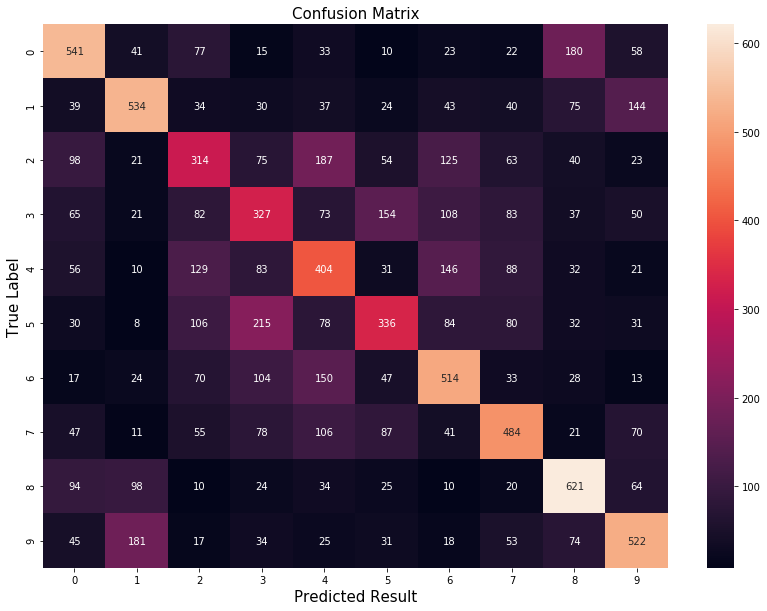

In [37]:

test_label = test_label.flatten()
result_visualization = np.zeros((numberOfClass, numberOfClass)) 
for i in range(len(test_label)):
    row = best_model_on_test[1][i]
    column = best_model_on_test[0][i]
    result_visualization[row][column] += 1
result_visualization # row results the true value, column results predicted value

TP = np.zeros((1,numberOfClass)).flatten()
FP = np.zeros((1,numberOfClass)).flatten()
TN = np.zeros((1,numberOfClass)).flatten()
FN = np.zeros((1,numberOfClass)).flatten()
Accuracy = np.zeros((1,numberOfClass)).flatten()
Precision = np.zeros((1,numberOfClass)).flatten()
Recall = np.zeros((1,numberOfClass)).flatten()
F1 = np.zeros((1,numberOfClass)).flatten()

sum_confus = np.sum(result_visualization)
for i in range(numberOfClass):
  TP[i] = result_visualization[i][i]
  FP[i] = np.sum(result_visualization[:,i])-TP[i]
  FN[i] = np.sum(result_visualization[i,:])-TP[i]
  TN[i] = sum_confus - FP[i] - FN[i] + TP[i]

  Accuracy[i] = (TP[i] + TN[i])/(TP[i]+FP[i]+TN[i]+FN[i])
  Precision[i] = TP[i]/(TP[i]+FP[i])
  Recall[i] = TP[i]/(TP[i] + FN[i])
  F1[i] = 2*Precision[i]*Recall[i]/(Precision[i]+Recall[i])
  print('\n')
  print('Class {} \n Acc: {}, \n Pres: {}, \n Rec: {}, \n F1: {}'.format(i,Accuracy[i],Precision[i],Recall[i],F1[i]))
  print('TP: {}, FP: {}, FN: {}, TN: {}'.format(TP[i],FP[i],FN[i],TN[i]))
print('Acc ave: {}, Precision ave: {}, Recall ave: {}, F1 ave: {}'.format(np.mean(Accuracy),
                                                                          np.mean(Precision),
                                                                          np.mean(Recall),
                                                                          np.mean(F1)))
# df = pd.DataFrame(result_visualization, index = [i for i in range(10)], columns = [i for i in range(10)])
# pl.figure(figsize= (10,7))
# pl.xlabel('xxx',fontsize=12)
# pl.ylabel('yyy',fontsize=12)
# sn.heatmap(df, annot=True, fmt='g')
df = pd.DataFrame(result_visualization, index = [i for i in range(numberOfClass)], columns = [i for i in range(numberOfClass)])
f, ax = pl.subplots(figsize=(14, 10))
sn.heatmap(df, annot=True, fmt='g')
ax.set_title("Confusion Matrix", fontsize = 15)
ax.set_xlabel('Predicted Result', fontsize= 15)
ax.set_ylabel("True Label", fontsize= 15)
f.savefig('confusion_matrix.jpg', dpi=100, bbox_inches='tight')